In [1]:
#General DS Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as stats

# working with dates
from datetime import datetime
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

#My imports
import model as m
import wrangle as w
import explore as e

#warnings
import warnings
warnings.filterwarnings('ignore')
# plotting defaults
#define font family to use for all text
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rc('figure', figsize=(12, 8))
plt.style.use('seaborn-darkgrid')

# Aquire
* Data aquired from data.boston.gov 'Crime Incident Reports as .CSV files by year
* Crime Incident Reports were collected beginning in 2015, and the data spans to present
* I combined the annual CSV files into one CSV, containing 652,418 rows and 17 features before cleaning
* Each row represents a crime reported to Boston Police (see further explanation re: Unique Incident Numbers)
* Each columns represents a feature of the crime, such as offense type, location, or time the crime occured

# Prepare
###### Prepare Actions:
* Renamed columns to improve readability
* Checked that column data types were appropriate, changed data types when necessary
* Removed white space from values in object columns
* Checked for null values in the data, imputing where appropriate (location null values were not addressed for this iteration)
* Outliers were not removed in this iteration
* Utilized string functions to clean column data information

In [2]:
#Import our data from a .csv file, take a peek
df = w.get_clean_data()
df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
0,I192068249,2647,other,threats to do bodily harm,B2,280,0,2015-08-28 10:20:00,2015,8,Friday,10,Part Two,WASHINGTON ST,42.330119,-71.084251,"(42.33011862, -71.08425106)"
1,I192061894,1106,confidence games,fraud - credit card / atm fraud,C11,356,0,2015-08-20 00:00:00,2015,8,Thursday,0,Part Two,CHARLES ST,42.300605,-71.061268,"(42.30060543, -71.06126785)"
2,I192038828,1107,fraud,fraud - impersonation,A1,172,0,2015-11-02 12:24:00,2015,11,Monday,12,Part Two,ALBANY ST,42.334288,-71.072395,"(42.33428841, -71.07239518)"
3,I192008877,1107,fraud,fraud - impersonation,E18,525,0,2015-07-31 10:00:00,2015,7,Friday,10,Part Two,WINGATE RD,42.237009,-71.129566,"(42.23700950, -71.12956606)"
4,I182090828,1102,fraud,fraud - false pretense / scheme,D4,159,0,2015-12-01 12:00:00,2015,12,Tuesday,12,Part Two,UPTON ST,42.342432,-71.072258,"(42.34243222, -71.07225766)"


### This dataframe, combined from Boston Crime data from 2015 to present, contains approximately 650,000 rows. Cleaning and imputing removed all null values except a small percentage within location data (3.5 percent). I elected to keep these nulls, and re-evaluate for future projects using this data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 652418 entries, 0 to 652417
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   incident_number      652418 non-null  object 
 1   offense_code         652418 non-null  int64  
 2   offense_code_group   652418 non-null  object 
 3   offense_description  652418 non-null  object 
 4   district             648116 non-null  object 
 5   reporting_area       652418 non-null  object 
 6   shooting             652418 non-null  int64  
 7   occurred_on_date     652418 non-null  object 
 8   year                 652418 non-null  int64  
 9   month                652418 non-null  int64  
 10  day_of_week          652418 non-null  object 
 11  hour                 652418 non-null  int64  
 12  ucr_part             652418 non-null  object 
 13  street               640529 non-null  object 
 14  lat                  629888 non-null  float64
 15  long             

### Unique incidents in this data

In [4]:
#Number of unique incidents in this data
df.incident_number.nunique()

610345

### 93.55 percent of the data involve unique incidents, meaning the vast majority of the data represents one row as one crime reported. Some of the data, where an incident number occurs multiple times, involve more serious offenses that are likely required to be tracked (arrests, firearm violations, aggravated assault):

In [5]:
#find duplicate rows across all columns
duplicateRows = df[df.duplicated()]
duplicateRows

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
1250,I152107190,413,aggravated assault,assault - aggravated - battery,B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part One,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1252,I152107190,111,homicide,"murder, non-negligient manslaughter",B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part One,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1254,I152107190,3125,warrant arrests,warrant arrest,B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part Three,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
1256,I152107190,1501,firearm violations,"weapon - firearm - carrying / possessing, etc",B3,427,1,2015-12-29 08:47:00,2015,12,Tuesday,8,Part Two,WILMORE ST,42.277964,-71.092463,"(42.27796370, -71.09246318)"
2438,I152105851,413,aggravated assault,assault - aggravated - battery,E13,302,1,2015-12-23 15:39:00,2015,12,Wednesday,15,Part One,CENTRE ST,42.322838,-71.100967,"(42.32283759, -71.10096723)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353245,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353246,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353248,I070720870-00,802,simple assault,assault & battery,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Two,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"
353249,I070720870-00,3125,warrant arrests,warrant arrest,B2,318,0,2018-12-13 00:00:00,2018,12,Thursday,0,Part Three,BROOKLEDGE ST,42.309563,-71.089902,"(42.30956305, -71.08990197)"


## Extracting Fraud Crimes

#### I experimented with different methods of quantifying and specifying fraud crimes within this dataset. Several features that were important were:

- **"offense_code"**: Boston Police numeric offense codes to identify a crime type/subtype. Documentation provided with this data gave key/value information indicating fraud type crimes:
    - 1101 (Passing worthless checks) to 1109 (Wire Fraud), inclusive (ten (10) offense codes indicating fraud charges)
    - Link to more information: __[RMS Offense Codes](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/3aeccf51-a231-4555-ba21-74572b4c33d6)__

- **"offense_code_group"**: Boston Police internal categorization of offense description
    - This field had approximately 300,000 null values
    
- **"offense_description"**: Primary descriptor of incident    

- Link to more information: __[Crime Incident Field Explanation](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/9c30453a-fefa-4fe0-b51a-5fc09b0f4655)__

#### **I chose to use utilize all rows that contained "fraud" within the offense_description field, as this method returned the most results:**

In [6]:
#Creating a new dataframe for only offenses containing fraud in their crime description:
fraud_df = w.create_fraud_df(df)
fraud_df.head()

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,year,month,day_of_week,hour,ucr_part,street,lat,long,location,count_of_crime
date,,,,,,,,,,,,,,,,,
2015-06-15,I152054354,1106,confidence games,fraud - credit card / atm fraud,D4,624,0,2015,6,Monday,17,Part Two,LANSDOWNE ST,42.347174,-71.096444,"(42.34717363, -71.09644390)",1
2015-06-15,I152049560,1102,fraud,fraud - false pretense / scheme,E18,519,0,2015,6,Monday,12,Part Two,RIVER ST,42.257191,-71.120018,"(42.25719149, -71.12001776)",1
2015-06-15,I162055778,1102,fraud,fraud - false pretense / scheme,D4,159,0,2015,6,Monday,9,Part Two,DARTMOUTH ST,42.342830,-71.073747,"(42.34283015, -71.07374670)",1
2015-06-15,I152049596,1106,confidence games,fraud - credit card / atm fraud,B3,470,0,2015,6,Monday,13,Part Two,COLORADO ST,42.277793,-71.099172,"(42.27779311, -71.09917239)",1
2015-06-15,I152049603,1102,fraud,fraud - false pretense / scheme,D4,128,0,2015,6,Monday,13,Part Two,STUART ST,42.349836,-71.071051,"(42.34983631, -71.07105135)",1


In [7]:
#These offenses contained 21, 247 crimes from June 2015 to present
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21247 entries, 2015-06-15 to 2022-12-08
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   incident_number      21247 non-null  object 
 1   offense_code         21247 non-null  int64  
 2   offense_code_group   21247 non-null  object 
 3   offense_description  21247 non-null  object 
 4   district             21109 non-null  object 
 5   reporting_area       21247 non-null  object 
 6   shooting             21247 non-null  int64  
 7   year                 21247 non-null  int64  
 8   month                21247 non-null  int64  
 9   day_of_week          21247 non-null  object 
 10  hour                 21247 non-null  int64  
 11  ucr_part             21247 non-null  object 
 12  street               21166 non-null  object 
 13  lat                  21049 non-null  float64
 14  long                 21049 non-null  float64
 15  location           

# Exploration

##### Train Test Split based on Pandemic Starting:
* On March 10, 2020, Governor Baker declared a state of emergency
* On March 15, 2020, Mayor Marty Walsh declared a state of emergency for the city of Boston
* Since the timeline is so close, I will elect to use March 15, 2020 to begin test data
* Validate data will be March 15, 2019 to March 14, 2020 (One year)
* Train data will be from March 15, 2017 to March 15, 2019 (Two Years)

In [8]:
train, validate, test = e.train_validate_test_split(fraud_df)

In [9]:
train.head()

,count_of_crime
date,
2017-03-14,4
2017-03-15,4
2017-03-16,6
2017-03-17,6
2017-03-18,8


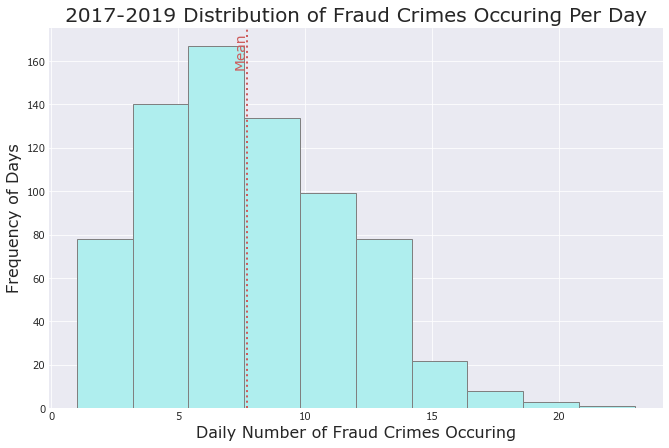

In [10]:
#Visualize distribution of target variable 
e.target_dist_viz(train)

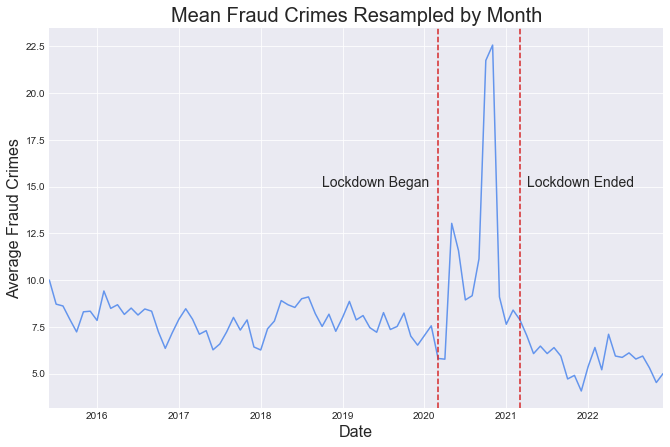

In [11]:
##Resample by month to visualize 2015-2022 fraud crimes
e.monthly_fraud_viz(fraud_df)

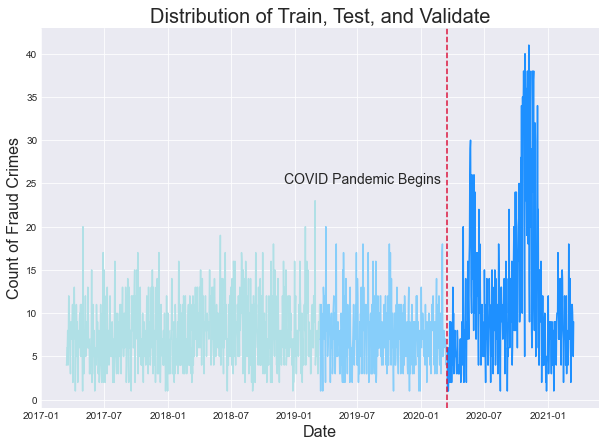

In [12]:
e.train_test_viz(train, validate, test)